# <center>Preprocessing</center>

## Import packages

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import imutils

In [2]:
%run "../scripts/image_loading.py"
    
%run "../scripts/image_saving.py"

# Load the saved dataset

When loaded, images are resized to 150x150.

In [3]:
#load the training dataset
train_dataset = tf.data.TFRecordDataset('../data/interim/train_data.tfrecord')
train_dataset = train_dataset.map(parse_example)

#load the test dataset
test_dataset = tf.data.TFRecordDataset('../data/interim/test_data.tfrecord')
test_dataset = test_dataset.map(parse_example)


The first step in preprocessing is to encode the labels, we group the dataset into batches.

In [4]:
#def preprocess_labels(image, label):
   # label = tf.one_hot(label, depth=4)  
   # return image, label

def preprocess_dataset(dataset, batch_size=32): 
    dataset = dataset.batch(batch_size)  
    dataset = dataset.prefetch(tf.data.AUTOTUNE)  
    return dataset

In [5]:
train_dataset = preprocess_dataset(train_dataset)

#test_dataset = test_dataset.map(preprocess_labels)
test_dataset = preprocess_dataset(test_dataset)


We then crop the images to help focus on the brain area, removing unnecessary background, before cropping, a 5x5 gaussian filter was applied to remove noise.

In [6]:
def crop_image(img):

    img = img.numpy().astype("uint8")
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

	
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    resized_img = cv2.resize(new_img, [256,256])
    return resized_img

Additionaly, we define a function to enhance the contrast of images

In [7]:
def enhance_contrast(image, contrast_factor=1.5):
    image = tf.image.adjust_contrast(image, contrast_factor)
    return image

Let's visualize a sample of images before and after cropping and contrst enhancement.

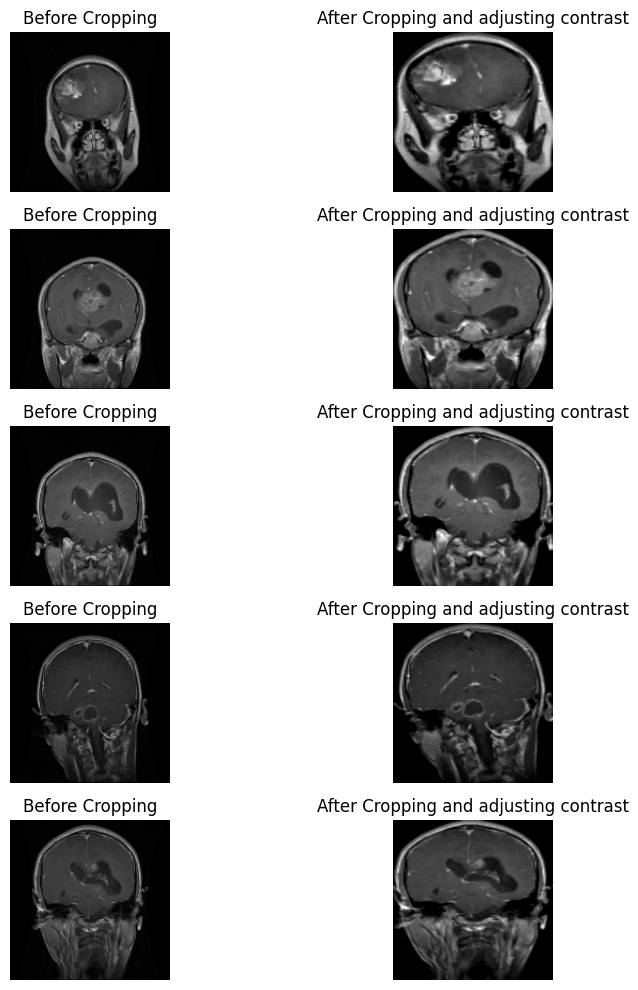

In [8]:
sample_batch = next(iter(train_dataset.take(1)))  

images, labels = sample_batch

num_images_to_show = 5
fig, axes = plt.subplots(num_images_to_show, 2, figsize=(10, 10))

for i in range(num_images_to_show):
    ax_before, ax_after = axes[i]
    
    # Get the image from the batch
    #image = (images[i]*255).numpy().astype("uint8") 
    
    # Crop the image
    cropped_image = enhance_contrast(crop_image(images[i]))/255
    
    # Plot before cropping
    ax_before.imshow(images[i]/255)
    ax_before.set_title("Before Cropping")
    ax_before.axis('off')
    
    # Plot after cropping
    ax_after.imshow(cropped_image)
    ax_after.set_title("After Cropping and adjusting contrast")
    ax_after.axis('off')

plt.tight_layout()
plt.show()

We save the preprocessed data into a tfrecord filename.

In [9]:
def write_cropped_to_tfrecord(dataset, tfrecord_filename):
    with tf.io.TFRecordWriter(tfrecord_filename) as writer:
        for batch_images, batch_labels in dataset:          
            batch_images = tf.map_fn(lambda x: float(enhance_contrast(crop_image(x))), batch_images)
            
            for img, label in zip(batch_images, batch_labels):
                example = image_to_example(img, label.numpy())
                writer.write(example.SerializeToString())
                
write_cropped_to_tfrecord(train_dataset, '../data/processed/cropped_train_data.tfrecord')
write_cropped_to_tfrecord(test_dataset, '../data/processed/cropped_test_data.tfrecord')